# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

keywords are unexpanded, not using


In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.563128,False,1.619841
1,-0.757476,True,6.361084
2,0.082374,True,7.954855
3,-1.519214,False,0.634509
4,-0.501509,True,4.896844
...,...,...,...
995,-0.182129,True,1.881910
996,0.890710,True,5.868430
997,-0.913784,False,-0.974408
998,-0.395729,False,0.006747


<AxesSubplot:xlabel='v0'>

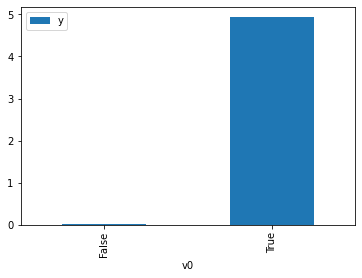

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

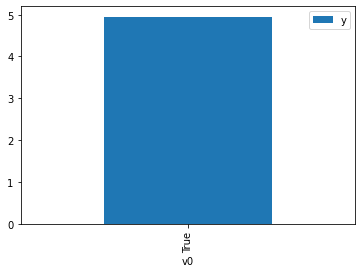

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.322864,False,0.506619,0.446723,2.238524
1,0.681457,False,-1.052059,0.388708,2.572628
2,0.425276,False,0.550296,0.429932,2.325949
3,0.470577,False,-0.219838,0.422554,2.366563
4,0.277876,False,-0.536746,0.454140,2.201965
...,...,...,...,...,...
995,0.571028,False,-0.206884,0.406320,2.461116
996,-0.959486,False,-0.461943,0.654785,1.527219
997,-0.491078,False,-2.497981,0.581315,1.720238
998,0.079449,False,0.866081,0.487052,2.053169


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-2.702730,True,4.603872,0.141710,7.056664
1,0.047163,True,4.457430,0.507575,1.970154
2,-1.482347,True,3.814479,0.271234,3.686853
3,-1.651699,True,4.206534,0.249522,4.007655
4,-0.969559,True,4.386705,0.343700,2.909512
...,...,...,...,...,...
995,-0.837337,True,6.062797,0.363828,2.748549
996,-0.541915,True,5.009058,0.410468,2.436245
997,-0.615884,True,4.172003,0.398601,2.508772
998,1.351525,True,6.892360,0.710748,1.406968


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.925
Model:                            OLS   Adj. R-squared (uncentered):              0.925
Method:                 Least Squares   F-statistic:                              6137.
Date:                Thu, 28 Jul 2022   Prob (F-statistic):                        0.00
Time:                        08:38:55   Log-Likelihood:                         -1399.1
No. Observations:                1000   AIC:                                      2802.
Df Residuals:                     998   BIC:                                      2812.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0870      0.031      2.814      0.005       0.026       0.148
x2             5.0149      0.045    110.281      0.000       4.926       5.104
==============================================================================
Omnibus:                        0.911   Durbin-Watson:                   2.096
Prob(Omnibus):                  0.634   Jarque-Bera (JB):                0.866
Skew:                          -0.072   Prob(JB):                        0.649
Kurtosis:                       3.015   Cond. No.                         1.48
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""